In [1]:
import gpytorch.kernels as kernel
import torch
import numpy as np
from src.test_statistics import *
from src.data import *
import random
import numpy as np
from src.test import *

In [2]:
X_ker = kernel.RBFKernel(ard_num_dims=3)
Y_ker = kernel.RBFKernel(ard_num_dims=1)

In [3]:
X_ker.lengthscale = 10

In [4]:
n=200
d=3
X = torch.randn((n,d))
Y = torch.randn(n)
T = (torch.randn((n))>0).float()

In [5]:
from src.utils import compute_median_heuristic
from sklearn.metrics import pairwise_distances

In [6]:
X_ker.lengthscale = compute_median_heuristic(X)
Y_ker.lengthscale = compute_median_heuristic(Y)

In [7]:
Y_ker.lengthscale

tensor([[0.9409]], grad_fn=<SoftplusBackward0>)

In [8]:
np.median(pairwise_distances(Y.reshape(-1,1)))

0.9408537

In [10]:
compute_median_heuristic(X)
Y = Y.unsqueeze(0)
median_heuristic = [np.median(pairwise_distances(Y[:, [i]].reshape(-1,1))) for i in range(Y.shape[1])]
median_heuristic = median_heuristic[0]
Y =Y.squeeze(0)

In [11]:
X.shape[0]

200

In [12]:
a =torch.tensor([1,1],dtype=float) 

In [13]:
data_train = Data_object(X,Y,T)
data_train_flip = Data_object(X,Y,1-T)

In [14]:
m=200
X = torch.randn((m,d))
Y = torch.randn(m)
T = (torch.randn((m))>0).float()

In [15]:
Y1 = torch.randn((1))

In [16]:
data_test = Data_object(X,Y,T)
data_test_flip = Data_object(X,Y,1-T)

In [17]:
W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),1,func="cme")
W1 = get_W_matrix(X_ker(data_train.X1).evaluate(),1,func="cme")

In [18]:
W0

tensor([[ 1.2078e-04, -2.5159e-08, -6.5279e-07,  ...,  1.0972e-09,
         -1.0136e-08, -2.4293e-09],
        [-2.5159e-08,  1.2078e-04, -8.7286e-08,  ...,  3.1159e-10,
         -4.2415e-08, -7.5733e-08],
        [-6.5279e-07, -8.7286e-08,  1.2086e-04,  ...,  3.5972e-09,
         -6.9829e-08, -1.1834e-07],
        ...,
        [ 1.0972e-09,  3.1159e-10,  3.5972e-09,  ...,  1.2076e-04,
         -1.0861e-08, -2.8690e-08],
        [-1.0136e-08, -4.2415e-08, -6.9829e-08,  ..., -1.0861e-08,
          1.2076e-04, -8.7319e-07],
        [-2.4293e-09, -7.5733e-08, -1.1834e-07,  ..., -2.8690e-08,
         -8.7319e-07,  1.2076e-04]], grad_fn=<CholeskyInverseBackward0>)

In [19]:
weights = 1/2*torch.ones(m)

In [20]:
K = ker(X_ker)
L = ker(Y_ker)

In [21]:
K(X,X)

tensor([[1.0000e+00, 5.9491e-01, 3.1622e-02,  ..., 4.0726e-05, 5.6564e-03,
         5.4079e-02],
        [5.9491e-01, 1.0000e+00, 8.0749e-03,  ..., 4.2357e-04, 7.0109e-03,
         1.8082e-02],
        [3.1622e-02, 8.0749e-03, 1.0000e+00,  ..., 7.0131e-04, 1.7665e-04,
         3.1817e-01],
        ...,
        [4.0726e-05, 4.2357e-04, 7.0131e-04,  ..., 1.0000e+00, 2.5659e-05,
         1.4545e-04],
        [5.6564e-03, 7.0109e-03, 1.7665e-04,  ..., 2.5659e-05, 1.0000e+00,
         4.3951e-06],
        [5.4079e-02, 1.8082e-02, 3.1817e-01,  ..., 1.4545e-04, 4.3952e-06,
         1.0000e+00]], grad_fn=<ExpBackward0>)

In [22]:
Y_ker.lengthscale

tensor([[0.9409]], grad_fn=<SoftplusBackward0>)

In [23]:
c = (data_test.T - weights)/(weights*(1-weights))
c

tensor([-2.,  2., -2.,  2.,  2., -2., -2.,  2., -2.,  2.,  2., -2., -2.,  2.,
         2.,  2.,  2.,  2.,  2.,  2., -2.,  2.,  2.,  2.,  2., -2.,  2., -2.,
        -2., -2., -2.,  2., -2., -2.,  2., -2.,  2., -2.,  2.,  2., -2.,  2.,
        -2., -2.,  2., -2., -2., -2., -2.,  2., -2., -2., -2., -2.,  2., -2.,
         2.,  2., -2.,  2., -2.,  2., -2.,  2., -2.,  2., -2., -2., -2.,  2.,
         2.,  2., -2.,  2., -2., -2.,  2., -2.,  2., -2.,  2.,  2.,  2.,  2.,
        -2., -2., -2., -2., -2.,  2.,  2., -2., -2.,  2., -2., -2.,  2.,  2.,
         2.,  2., -2.,  2., -2.,  2., -2.,  2.,  2., -2., -2., -2., -2.,  2.,
         2., -2.,  2., -2., -2.,  2., -2., -2.,  2., -2.,  2., -2.,  2.,  2.,
         2., -2.,  2., -2.,  2.,  2.,  2.,  2.,  2., -2.,  2., -2.,  2., -2.,
         2., -2., -2., -2.,  2., -2.,  2., -2., -2., -2., -2.,  2.,  2., -2.,
        -2.,  2.,  2., -2., -2.,  2.,  2., -2., -2., -2.,  2.,  2.,  2.,  2.,
        -2.,  2.,  2.,  2.,  2., -2.,  2.,  2.,  2.,  2., -2., -

In [24]:
data_train.Y.shape

torch.Size([200, 1])

In [25]:
L(data_train.Y0,data_train.Y).shape

torch.Size([90, 200])

In [26]:
DATE_test_stat(data_train,data_test,X_ker,Y_ker,weights,W0,W1)

0.006199559662491083

In [27]:
DETT_test_stat(data_train,data_test,X_ker,Y_ker,weights,W1)

0.0015518668806180358

In [28]:
L(data_train.Y0,data_test.Y)@ c

tensor([ 1.9322, -8.5568, -6.7152,  3.9547, 10.2388, -8.1273,  7.9266, 11.2351,
         3.9770,  9.3506,  9.4653,  4.0750, 10.3650, -2.1730, -0.6538, -3.8407,
         5.7702, 11.7546, -7.6925,  7.3833,  8.4080, 11.2498,  8.5964, -8.2646,
        11.6018,  3.9738, -5.7498,  9.8972, -6.5912, -0.5222,  8.7060,  4.4358,
         0.6020, -5.8372, -6.3293, -7.5724,  4.4632,  4.6306, 11.5758,  6.5703,
         3.5406,  8.3184,  3.3264,  7.3452, 10.4919, 11.3228, -5.1918, -6.3613,
         5.0083, -0.1549, -2.7545,  4.2377, -3.7231,  6.8549,  9.7361, 11.7159,
        10.3021, -8.3225,  0.8856, 11.7480, -7.2409,  5.1315, -3.8210,  2.7061,
         3.5989, -0.0344, -7.7508, -6.7914, 11.7161,  9.3032, -7.5342, -0.2584,
        -7.0361, 11.6075,  6.2458,  4.0541,  9.8376, 11.2436,  8.2408,  7.7479,
        -7.0004,  8.8656,  5.6858, -2.7696, 11.0996,  6.0206,  9.5763, -5.9353,
        -3.0510, -8.5675], grad_fn=<MvBackward0>)

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
weights_model = LogisticRegression()

In [31]:
weights_model.fit(data_train.X,data_train.T)
weights_train = weights_model.predict_proba(data_train.X)[:,1]
weights_test = weights_model.predict_proba(data_test.X)[:,1]

In [32]:
kernel_permutation_test(data_train,data_test,X_ker,Y_ker,weights_model,test_stat="DATE",n_bins=10,n_permutations=100,reg=1,KMM_weights=True)

/opt/miniconda3/lib/python3.8/site-packages/qpth/qp.py:83: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:3427.)
  e, _ = torch.eig(Q[i])


TypeError: 'int' object is not subscriptable

In [ ]:
g = lambda X: X[:,0]**2 + X[:,1] 

mu = torch.tensor([0,0.5])
sigma = ["ID"]
g_0 = g
g_1 = g
noise = 0.1
n_sample =200

In [ ]:
a = shift_data_simulation(mu,sigma,g_0,g_1,noise,n_sample)
b = shift_data_simulation(mu,sigma,g_0,g_1,noise,n_sample)

/Users/jakefawkes/Python/DR_distributional_test/src/data.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor(mu)


In [ ]:
a.Y

tensor([-4.4076e-01,  2.4920e-01, -4.7165e-03, -6.4171e-01,  1.3523e+00,
         2.5778e+00,  3.3083e+00,  2.6336e-03, -4.0707e-01,  7.8950e-01,
         6.3185e+00, -2.7712e-01,  1.0936e+00,  3.8727e+00, -7.6570e-02,
        -3.1872e-01,  2.1200e+00,  1.7540e-01,  3.5271e+00,  9.6172e-02,
         1.0003e+00, -1.7119e-01,  3.0533e+00,  1.2901e+00, -5.1598e-01,
         3.8865e-01,  1.9824e+00,  2.6087e+00, -8.2681e-01,  1.3283e+00,
         1.1754e+00,  1.5259e+00,  2.2519e+00,  6.7365e-01,  1.0342e+00,
         1.1624e+00,  1.8244e+00, -5.5517e-01, -6.8656e-01,  4.3305e-01,
         6.2912e-01,  1.1520e+00,  5.2988e+00, -2.0027e-01,  1.8217e+00,
         4.2160e+00, -7.5827e-02,  7.4735e-01,  2.6669e+00,  2.7883e+00,
         5.4554e-01, -4.9162e-01, -3.0774e+00,  1.0307e+00,  1.6118e+00,
         1.7389e+00, -1.0074e+00,  8.6697e-01, -4.6437e-01,  3.4430e+00,
         5.0789e+00,  3.7458e+00,  1.2542e+00,  4.9025e+00, -5.0517e-01,
         3.4813e+00, -1.3086e+00,  1.3757e+00, -1.4

In [ ]:
import yaml
import src.data as data

In [ ]:
f = getattr(data,"shift_data_simulation")

In [ ]:
with open("/Users/jakefawkes/Python/DR_distributional_test/config/run_simulated_shift_experiment.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [ ]:
cfg

{'experiment': {'n_iter': 30,
  'test_stat': ['DATE', 'DETT'],
  'ker_regress': ['cme', 'zero'],
  'weights_model': 'Linear',
  'X_ker': 'RBF',
  'Y_ker': 'RBF',
  'significance_level': 0.05,
  'n_bins': 20,
  'cme_reg': 0.01,
  'permute_weights': True,
  'KMM_weights': True},
 'data': {'generator': 'Logistic_Regression',
  'n_train_sample': 500,
  'n_test_sample': 500,
  'arguments': {'alpha_vec': [0.1, 0.2, 0.3, 0.4, 0.5],
   'beta_vec': [0.1, 0.2, 0.3, 0.4, 0.5],
   'beta_scalar': 0,
   'effect_var': 'Unif',
   'noise_Y': 0.2}}}

In [ ]:
def make_data(cfg):
    if cfg["data"]["generator"] == "shift_data_simulation":
        function_dict = {}
        for key in cfg["data"]["functions"]:
            function_dict[key] = getattr(data,cfg["data"]["functions"][key])
    data_train = shift_data_simulation(n_sample=cfg["data"]["n_train_sample"],**function_dict,**cfg["data"]["arguments"])
    data_test = shift_data_simulation(n_sample=cfg["data"]["n_test_sample"],**function_dict,**cfg["data"]["arguments"])
    return data_train,data_test

In [ ]:
a = shift_data_simulation(mu,sigma,g_0,g_1,noise,n_sample)

In [ ]:
float(True)

1.0

In [ ]:
import pandas as pd

In [ ]:
df_dict = {"Y":a.Y,"T":a.T}
df = pd.DataFrame(np.array(a.X))
df.columns = ["X"+str(i) for i in df.columns]

In [ ]:
df["Y"] = a.Y
df["T"] = a.T

In [ ]:
df

,X0,X1,Y,T
0,0.506237,0.451246,0.826996,0.0
1,-1.229592,1.539003,3.100840,0.0
2,0.613343,-1.057146,-0.650670,0.0
3,1.497429,-0.366604,1.956600,0.0
4,2.038250,1.707132,5.833252,0.0
...,...,...,...,...
195,-0.338577,1.410334,1.551149,1.0
196,-1.204343,0.365031,1.766839,1.0
197,0.277565,-0.303279,-0.209090,1.0
198,0.859596,1.279037,2.037700,1.0


In [ ]:
import seaborn as sns

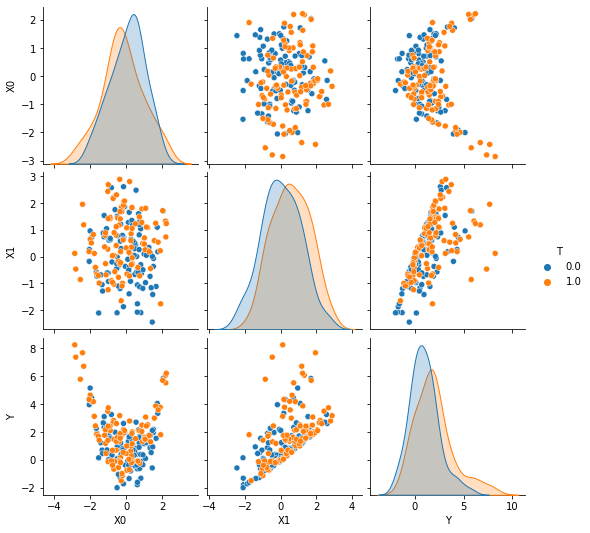

In [ ]:
b = sns.pairplot(df, hue ="T")

In [ ]:
from datetime import datetime


In [ ]:
now = datetime.now()

In [ ]:
now.strftime("%m-%d %H:%M:%S")

'08-07 16:15:09'

In [ ]:
df_dict = {"weights" : weights_model.predict_proba(data_test.X)[:,1], "T" : data_test.T}

In [ ]:
df = pd.DataFrame(df_dict)

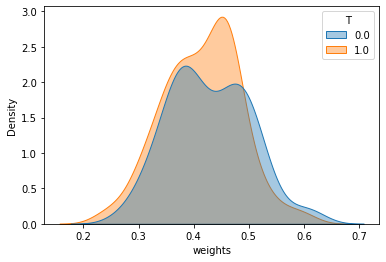

In [ ]:
a = sns.kdeplot(data = df, x="weights", hue ="T",fill=True, alpha = 0.4)

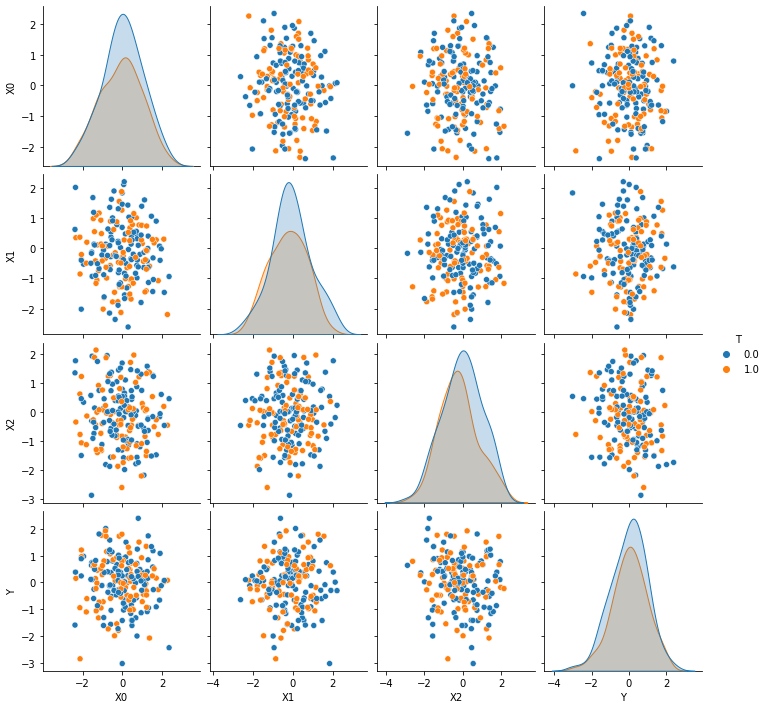

In [ ]:
a = data_train.plot_data()

In [ ]:
if "str":
    print("y")

y


In [ ]:
a =[1,1]

In [ ]:
if type(a) == list:
    print("y")

y


In [ ]:
def linear_data_simulation(alpha_vec,beta_vec,beta_scalar,effect_var,noise_Y,n_sample):

    alpha_vec = torch.tensor(alpha_vec).float()
    beta_vec = torch.tensor(beta_vec).float()

    d = len(alpha_vec)

    X = torch.randn((n_sample,d)).float()
    T = torch.bernoulli(torch.sigmoid( X @ alpha_vec ))
    
    if effect_var == "const":
        effect_vec = torch.ones(n_sample)

    if effect_var == "Ber":
        effect_vec = 2*torch.bernoulli(1/2*torch.ones(n_sample))-1

    if effect_var == "Unif":
        effect_vec = 2*torch.rand(n_sample)-1

    Y =  X @ alpha_vec + beta_scalar * effect_vec + noise_Y * torch.randn((n_sample))

    return Data_object(X,Y,T)

In [ ]:
alpha_vec = [1,1,1]
beta_vec = [1,1,1]
beta_scalar = 1
effect_var = "Ber"
noise_Y = 1
n_sample = 100
a= linear_data_simulation(alpha_vec,beta_vec,beta_scalar,effect_var,noise_Y,n_sample)

In [ ]:
a.Y

tensor([-0.7534,  0.4781,  0.6498,  1.2084,  0.8164,  2.8456, -1.6472, -0.7281,
        -0.8523, -3.5423,  0.9697, -3.9903,  2.4608,  3.0891, -4.1880, -2.5331,
         2.0088, -1.7169, -0.0397, -1.1688, -0.9790, -1.1457,  0.2360,  0.4737,
         1.1288, -1.9912,  3.2898,  3.1593,  0.2823, -2.3270,  1.1898, -2.2869,
         0.8598, -0.4671, -1.7941, -2.5219,  3.8958,  0.8934, -3.6647,  1.1553,
         0.2878, -3.4399, -2.2679, -0.3001, -4.8921, -1.7277, -0.4373,  2.2502,
        -3.3469, -2.9482,  4.1675, -0.4814, -1.8080,  3.6702,  1.4431,  0.8931,
         0.4945,  1.7228, -0.5799, -2.6967,  1.0637, -0.4525, -5.1098, -4.2689,
        -1.2279, -2.6315, -2.8490,  2.9144, -3.3992,  4.9272,  1.2692,  0.4488,
         2.1326, -2.2089,  3.7264,  0.4606, -2.8470, -3.1689, -1.2112, -2.4276,
        -0.0067,  1.1436,  1.5501, -0.9217,  0.5071, -0.6788, -0.9320, -1.9284,
        -5.9375,  0.3532,  1.0625,  0.3237, -1.6031, -0.7126, -0.3942,  4.9858,
        -1.2838,  1.6137,  0.1130, -1.86

In [ ]:
alpha_vec = torch.tensor(alpha_vec).float()
beta_vec = torch.tensor(beta_vec).float()

d = len(alpha_vec)

X = torch.randn((n_sample,d)).float()
T = torch.bernoulli(torch.sigmoid( X @ alpha_vec ))

if effect_var == "const":
    effect_vec = torch.ones(d)

if effect_var == "Ber":
    effect_vec = 2*torch.bernoulli(1/2*torch.ones(n_sample))-1

if effect_var == "Unif":
    effect_vec = 2*torch.rand(d)-1

Y =  X @ alpha_vec + beta_scalar * effect_vec + noise_Y * torch.randn((n_sample))


In [ ]:
def cme_cross_validate_target(data_train,data_val,X_ker,Y_ker,reg_param):
        
        K = ker(X_ker)
        L = ker(Y_ker)

        W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),reg_param,"cme")
        W1 = get_W_matrix(X_ker(data_train.X1).evaluate(),reg_param,"cme")

        val_stat_0 = torch.trace(L(data_val.Y0,data_val.Y0) -2 * K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_val.Y0)))+ (K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_train.Y0)@ (W0 @ (K(data_train.X0,data_val.X0)))))))
        val_stat_1 = torch.trace(L(data_val.Y1,data_val.Y1) -2 * K(data_train.X1,data_val.X1).T @ (W1 @ (L(data_train.Y1,data_val.Y1)))+ (K(data_train.X1,data_val.X1).T @ (W0 @ (L(data_train.Y1,data_train.Y1)@ (W0 @ (K(data_train.X1,data_val.X1)))))))
        val_stat = val_stat_0+val_stat_1
        return val_stat

In [ ]:
def cme_cross_validate_target(data_train,data_val,X_ker,Y_ker,reg_param):
        
        K = ker(X_ker)
        L = ker(Y_ker)

        W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),reg_param,"cme")
        W1 = get_W_matrix(X_ker(data_train.X1).evaluate(),reg_param,"cme")

        val_stat_0 = torch.trace(L(data_val.Y0,data_val.Y0) -2 * K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_val.Y0))) + (K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_train.Y0)@ (W0 @ (K(data_train.X0,data_val.X0)))))))
        val_stat_1 = torch.trace(L(data_val.Y1,data_val.Y1) -2 * K(data_train.X1,data_val.X1).T @ (W1 @ (L(data_train.Y1,data_val.Y1))) + (K(data_train.X1,data_val.X1).T @ (W1 @ (L(data_train.Y1,data_train.Y1)@ (W1 @ (K(data_train.X1,data_val.X1)))))))
        val_stat = val_stat_0+val_stat_1
        return val_stat

In [ ]:
data_train = linear_data_simulation(alpha_vec,beta_vec,beta_scalar,effect_var,noise_Y,n_sample)
data_val = linear_data_simulation(alpha_vec,beta_vec,beta_scalar,effect_var,noise_Y,n_sample)
cme_cross_validate_target(data_train,data_val,X_ker,Y_ker,reg_param=1)

/var/folders/3k/2lkktjyj2r74wt_611v45qs00000gn/T/ipykernel_53525/3842994627.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_vec = torch.tensor(alpha_vec).float()
/var/folders/3k/2lkktjyj2r74wt_611v45qs00000gn/T/ipykernel_53525/3842994627.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  beta_vec = torch.tensor(beta_vec).float()


tensor(99.9141, grad_fn=<AddBackward0>)

In [ ]:
from src.utils import cme_cross_validate_weighted,kernel_mean_matching

In [ ]:
kernel_mean_matching(X_ker,data_val.X0,data_val.X).shape

torch.Size([1, 42])

In [ ]:
cme_cross_validate_weighted(data_train,data_val,X_ker,Y_ker,reg_param=1,T_val=0)

RuntimeError: The size of tensor a (42) must match the size of tensor b (48) at non-singleton dimension 1

In [ ]:
def cme_cross_validate_weighted(data_train,data_val,X_ker,Y_ker,reg_param,T_val=0):
        
        K = ker(X_ker)
        L = ker(Y_ker)

        X_train_data = data_train.X[data_train.T == T_val]
        Y_train_data = data_train.Y[data_train.T == T_val]

        W = get_W_matrix(X_ker(X_train_data).evaluate(),reg_param,"cme")

        X_val_data = data_val.X[data_val.T == T_val]
        Y_val_data = data_val.Y[data_val.T == T_val]

        return_weights = kernel_mean_matching(X_ker, X_val_data, data_val.X)
        return_weights_matrix = torch.diag(return_weights)

        val_stat = torch.trace(return_weights_matrix@(L(Y_val_data,Y_val_data) -2 * K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_train_data))) + (K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_train_data)@ (W @ (K(X_train_data,X_val_data))))))))
        return val_stat

In [ ]:
T_val = 0
reg_param = 1
X_train_data = data_train.X[data_train.T == T_val]
Y_train_data = data_train.Y[data_train.T == T_val]

W = get_W_matrix(X_ker(X_train_data).evaluate(),reg_param,"cme")

X_val_data = data_val.X[data_val.T == T_val]
Y_val_data = data_val.Y[data_val.T == T_val]

return_weights = kernel_mean_matching(X_ker, X_val_data, data_val.X).squeeze(0)
return_weights_matrix = torch.diag(return_weights)

val_stat = torch.trace(return_weights_matrix@(L(Y_val_data,Y_val_data) -2 * K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_val_data))) + (K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_train_data)@ (W @ (K(X_train_data,X_val_data))))))))

In [ ]:
(K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_train_data)@ (W @ (K(X_train_data,X_val_data)))))).shape

torch.Size([42, 42])

In [ ]:
(K(X_train_data,X_val_data).T @ (W @ (L(Y_train_data,Y_val_data)))).shape

torch.Size([42, 42])

In [ ]:
torch.diag(return_weights.squeeze(0))

tensor([[ 6.5199e+01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  5.9489e+02,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -3.1570e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  7.4104e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          6.4893e+01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -1.8914e-01]], grad_fn=<DiagBackward0>)

In [ ]:
data_val.T.sum()

tensor(46.)

In [ ]:
result_dict = kernel_permutation_test(data_train,data_test,X_ker,Y_ker,weights_model,test_stat="DATE",n_bins=10,n_permutations=100,reg=1,KMM_weights=True)

RuntimeError: Q is not SPD.

In [ ]:
len(data_val.T)

100

In [ ]:
X_val_data = data_val.X[data_val.T == 0]

In [ ]:
kernel_mean_matching(X_ker,data_test.X1,data_test.X)

RuntimeError: Q is not SPD.

In [ ]:
data_train.X

tensor([[ 0.2245, -0.0372],
        [ 0.2849,  1.3831],
        [-2.4144, -1.4844],
        [-1.0680,  0.5263],
        [ 0.9512, -1.5847],
        [ 0.4823, -0.4790],
        [-0.5240, -0.6070],
        [ 1.1552, -1.4885],
        [ 1.7344, -0.4447],
        [ 0.4220,  0.1468],
        [ 1.1870,  0.6172],
        [ 1.7036, -1.1028],
        [-0.8989,  0.4781],
        [-0.9170,  0.6102],
        [-0.4991,  0.3793],
        [ 0.3417, -0.9079],
        [ 0.9360, -0.6211],
        [ 1.1611,  1.1436],
        [ 0.6017,  0.3321],
        [-0.4207, -1.0678],
        [ 2.7563, -0.4940],
        [-1.5078,  0.6656],
        [-0.9820, -1.6307],
        [-1.7870,  0.8285],
        [ 0.2601,  0.8393],
        [ 0.6833,  0.6449],
        [-0.2842, -0.1314],
        [ 1.7600, -0.2359],
        [ 1.1459,  0.5760],
        [ 0.5180, -0.8124],
        [ 0.3778, -1.2391],
        [ 0.4066,  0.0221],
        [-1.2392,  0.2994],
        [-0.5706,  0.1944],
        [ 0.3937, -2.0141],
        [-0.2365, -1

In [ ]:
K = ker(X_ker)
L = ker(Y_ker)
W0 = get_W_matrix(X_ker(data_train.X0).evaluate(),1,"cme")
W1 = get_W_matrix(X_ker(data_train.X1).evaluate(),1,"cme")

In [ ]:
L(data_val.Y0,data_val.Y0) -2 * K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_val.Y0)))+ (K(data_train.X0,data_val.X0).T @ (W0 @ (L(data_train.Y0,data_train.Y0)@ (W0 @ (K(data_train.X0,data_val.X0))))))

tensor([[ 9.9650e-01,  9.2141e-01,  4.0444e-02,  ...,  1.4607e-03,
          4.4177e-03,  4.3555e-01],
        [ 9.2173e-01,  9.9683e-01,  1.1443e-02,  ...,  6.1118e-03,
         -3.8566e-04,  6.7134e-01],
        [ 3.8187e-02,  1.0576e-02,  9.9769e-01,  ..., -6.4834e-04,
          7.7048e-01, -2.7286e-03],
        ...,
        [-2.0275e-04,  5.5464e-03, -2.8002e-03,  ...,  9.9733e-01,
         -1.8889e-03,  8.1355e-02],
        [ 5.1566e-03,  1.2083e-03,  7.7167e-01,  ..., -2.3636e-05,
          9.9996e-01, -1.0561e-04],
        [ 4.3827e-01,  6.7275e-01,  2.3699e-04,  ...,  8.0030e-02,
         -3.4985e-04,  9.9782e-01]], grad_fn=<AddBackward0>)

In [ ]:
# Load config file
with open("config/wrapped_simulaton_cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

In [ ]:
cfg

{'moving_param': {'beta_scalar': True,
  'n_train_sample': False,
  'n_test_sample': False,
  'values': [0, 0.05]},
 'experiment': {'n_iter': 2,
  'test_stat': ['DATE', 'DETT'],
  'comparison_model': ['TMLE', 'DML'],
  'ker_regress': ['cme', 'zero'],
  'weights_model': 'MLP',
  'X_ker': 'RBF',
  'Y_ker': 'RBF',
  'significance_level': 0.05,
  'n_bins': 20,
  'cme_reg': 0.01,
  'permute_weights': True,
  'KMM_weights': True},
 'data': {'generator': 'linear_data_simulation',
  'n_train_sample': 50,
  'n_test_sample': 50,
  'arguments': {'alpha_vec': [0.1, 0.2, 0.3, 0.4, 0.5],
   'beta_vec': [0.1, 0.2, 0.3, 0.4, 0.5],
   'beta_scalar': 0.2,
   'effect_var': 'Unif',
   'noise_Y': 0.2}}}

In [ ]:
import doubleml as dml

In [ ]:
df = data_train.pd_df()

In [ ]:
X_cols = [col for col in df.columns if col.startswith("X")]

In [ ]:
dml_data = dml.DoubleMLData(df,y_col="Y",d_cols="T",x_cols = X_cols)

In [ ]:
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

learner = RandomForestRegressor(n_estimators = 500, max_features = 'sqrt', max_depth= 5)

ml_l_bonus = clone(learner)

ml_m_bonus = clone(learner)

learner = LassoCV()

ml_l_sim = clone(learner)

ml_m_sim = clone(learner)
obj_dml_plr_bonus = dml.DoubleMLPLR(dml_data, ml_l_bonus, ml_m_bonus)

In [ ]:
obj_dml_plr_bonus.fit()

KeyboardInterrupt: 

In [ ]:
obj_dml_plr_bonus.pval

array([0.98513103])

In [ ]:
from src.comparison_models import tmle_test

In [ ]:
tmle_test(data_test)

0.36474594203594113

In [ ]:
torch.concat([data_test.T,data_train.T])

tensor([1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
        1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.,
        0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 1., 1., 0., 1., 